In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt
from sklearn.neighbors import KNeighborsRegressor
import AISMapPlot as aismap

In [37]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_01min_s%d.pkl' % (s)))

In [38]:
positions

,Latitude,Longitude
0,52.8,NaN
1,NaN,4.80
2,NaN,6.00
3,NaN,7.20
4,NaN,8.60
5,NaN,9.81


In [39]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude', 'COG', 'SOG']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon', 'mins_to_sector_leave', 'sector_leave_cog', 'sector_leave_sog']])

In [40]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [41]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [42]:
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs=-1)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-6.116405797919628
-3.7062447576713007
-2.3243847373898996
-2.340975455989766
-8.206151197286584
-3.1167425565534765


In [43]:
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-6.85759195469664
-4.63718270715354
-2.69708771998416
-2.757761298170478
-8.642736619304404
-3.736886624233332


In [44]:
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p = 2,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs=-1)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-6.299743657115846
-3.9720021776254084
-2.413762271730533
-2.346101478658743
-8.269668558965577
-3.3118391684622694


In [45]:
knn_pos_list = []

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
    if s == 0:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lon'])
    else:
        knn_pos.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_pos_list.append(knn_pos)

In [46]:
knn_cog_list = []

for s in sectors:
    knn_cog = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)    
    knn_cog.fit(X_train[s], y_train[s]['sector_leave_cog'])
    knn_cog_list.append(knn_cog)

In [47]:
knn_sog_list = []

for s in sectors:
    knn_sog = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)    
    knn_sog.fit(X_train[s], y_train[s]['sector_leave_sog'])
    knn_sog_list.append(knn_sog)

In [48]:
knn_time_list = []
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
    knn_time.fit(X_train[s], y_train[s]['mins_to_sector_leave'])
    knn_time_list.append(knn_time)

In [49]:
# 51.99 4.06, cog, sog
lats = [51.99]
lons = [4.06]
cogs = [292.0]
sogs = [15.20]
for s in sectors:
    if s == 0:
        lat = sector_borders[0]
        lon = knn_pos_list[0].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
        cog = knn_cog_list[0].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
        sog = knn_sog_list[0].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
    else:
        lat = knn_pos_list[s].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
        lon = sector_borders[s]
        cog = knn_cog_list[s].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
        sog = knn_sog_list[s].predict([[lats[-1], lons[-1], cogs[-1], sogs[-1]]])[0]
    lats.append(lat)
    lons.append(lon)
    cogs.append(cog)
    sogs.append(sog)

print(lats)
print(lons)
print(cogs)
print(sogs)

[51.99, 52.8, 53.439992872416255, 53.76366473466051, 53.86254659731722, 53.949999999999996, 53.55]
[4.06, 4.169999999999998, 4.8, 6.0, 7.2, 8.6, 9.81]
[292.0, 29.0, 53.3304506216842, 74.02595945014004, 77.29259812286583, 113.05851868042392, 106.8453458989668]
[15.2, 13.0, 13.634833293735674, 13.849027466773386, 12.994664160007847, 15.08337143080014, 8.78498541669067]


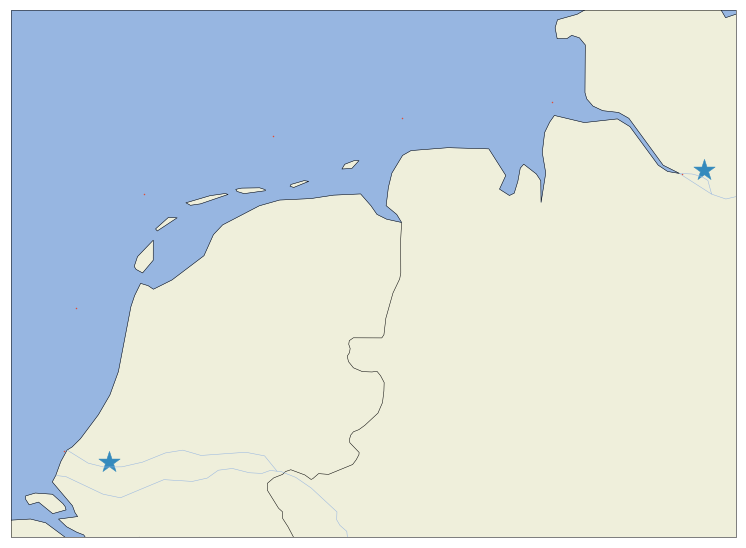

In [18]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))

In [50]:
# testing
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p = 2, algorithm = 'kd_tree', leaf_size = 100, weights = 'distance')
    scores = cross_val_score(knn_time, X[s], y[s]['Lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -24.752406
1 -> -11.880486
2 -> -9.702952
3 -> -9.211570
4 -> -37.861319
5 -> -14.231698


In [51]:
# current best
# 1 minute dataset
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance')
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -23.883889
1 -> -10.586396
2 -> -9.272385
3 -> -9.202995
4 -> -37.540664
5 -> -13.254482


In [161]:
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
    if s == 0:
        scores = cross_val_score(knn_pos, X[s], y[s]['sector_leave_lon'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
        print("%d -> %f" % (s, scores.mean()))
    else :
        scores = cross_val_score(knn_pos, X[s], y[s]['sector_leave_lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
        print("%d -> %f" % (s, scores.mean()))

0 -> -0.016268
1 -> -0.022834
2 -> -0.011620
3 -> -0.009410
4 -> -0.000775
5 -> -0.000074


In [53]:
for s in sectors:
    knn_sog = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
    scores = cross_val_score(knn_sog, X[s], y[s]['sector_leave_sog'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -1.596728
1 -> -0.692207
2 -> -0.696620
3 -> -0.926829
4 -> -1.684472
5 -> -1.488197


In [54]:
for s in sectors:
    knn_cog = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm='kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
    scores = cross_val_score(knn_cog, X[s], y[s]['sector_leave_cog'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -5.085145
1 -> -7.229788
2 -> -1.641299
3 -> -1.565643
4 -> -1.804844
5 -> -0.840960


In [141]:


from sklearn.ensemble import RandomForestRegressor
#for s in sectors:
rfr_time = RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 12, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 10, n_jobs = -1)
scores = cross_val_score(rfr_time, X[3], y[3]['mins_to_sector_leave'], cv = cv_splits[3], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (3, scores.mean()))

3 -> -6.138888


In [ ]:
# 1 min dataset, criterion mse
# time
# 0 -> -19.599084   RandomForestRegressor(n_estimators = 35, oob_score = 'true', max_depth = 20, random_state = 1, criterion = 'mse', max_features = 2, min_samples_leaf= 35, n_jobs = -1)
# 1 -> -6.993401    RandomForestRegressor(n_estimators = 35, random_state = 2, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 35, n_jobs = -1)
# 2 -> -4.617680    RandomForestRegressor(n_estimators = 50, oob_score = 'true', max_depth = 20, random_state = 3, criterion = 'mse', max_features = 3, min_samples_leaf= 35, n_jobs = -1)
# 3 -> -6.116497    RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 6, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 10, n_jobs = -1)
# 4 -> -32.356552   RandomForestRegressor(n_estimators = 35, oob_score = 'true', max_depth = 20, random_state = 2, criterion = 'mse', max_features = 2, min_samples_leaf= 35, n_jobs = -1)
# 5 -> -10.840728   RandomForestRegressor(n_estimators = 35, oob_score = 'true', criterion = 'mse',random_state = 1, max_features = 3, min_samples_leaf= 30, n_jobs = -1)


In [175]:
for s in sectors:
    rfr_pos = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
    if s == 0:
        scores = cross_val_score(rfr_pos, X[s], y[s]['sector_leave_lon'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
        print("%d -> %f" % (s, scores.mean()))
    else :
        scores = cross_val_score(rfr_pos, X[s], y[s]['sector_leave_lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
        print("%d -> %f" % (s, scores.mean()))

0 -> -0.015398
1 -> -0.021076
2 -> -0.006277
3 -> -0.005967
4 -> -0.000792
5 -> -0.000076


In [ ]:
# 1 min dataset, criterion mse
# position
# 0 -> -0.015382 RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 1 -> -0.021029 RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 2 -> -0.006202 RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 3 -> -0.005957 RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)

# knn better for these two
# 4 -> -0.000792   RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 20,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 30, n_jobs = -1)
# 5 -> -0.000076   RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 20,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 30, n_jobs = -1)

In [179]:
for s in sectors:
    rfr_cog = RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
    scores = cross_val_score(rfr_cog, X[s], y[s]['sector_leave_cog'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))


0 -> -4.837980
1 -> -6.916043
2 -> -1.443601
3 -> -1.448262
4 -> -1.687437
5 -> -0.772893


In [ ]:
#cog

# 0 -> -4.818081  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 1 -> -6.908563  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 2 -> -1.437228  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 3 -> -1.442693  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 4 -> -1.686204  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 5 -> -0.772149  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)

In [183]:
for s in sectors:
    rfr_sog = RandomForestRegressor(n_estimators = 60, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
    scores = cross_val_score(rfr_sog, X[s], y[s]['sector_leave_sog'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))


0 -> -1.506183
1 -> -0.667424
2 -> -0.649134
3 -> -0.891368
4 -> -1.636134
5 -> -1.410727


In [ ]:
# 0 -> -1.508407  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 1 -> -0.669519  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 2 -> -0.651048  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 3 -> -0.893188  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 4 -> -1.636083  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
# 5 -> -1.411056  RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)

In [188]:
#pos
rfr_pos_list = []
#sector 0
rfr_pos0 = RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_pos0.fit(X_train[0], y_train[0]['sector_leave_lon'])
rfr_pos_list.append(rfr_pos0)
#sector1
rfr_pos1 = RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_pos1.fit(X_train[1], y_train[1]['sector_leave_lat'])
rfr_pos_list.append(rfr_pos1)
#sector2
rfr_pos2 = RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_pos2.fit(X_train[2], y_train[2]['sector_leave_lat'])
rfr_pos_list.append(rfr_pos2)
#sector3
rfr_pos3 = RandomForestRegressor(n_estimators = 100, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_pos3.fit(X_train[3], y_train[3]['sector_leave_lat'])
rfr_pos_list.append(rfr_pos3)
#sector4
rfr_pos4 = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
rfr_pos4.fit(X_train[4], y_train[4]['sector_leave_lat'])
rfr_pos_list.append(rfr_pos4)
#sector5
rfr_pos5 = KNeighborsRegressor(n_neighbors = 10, p = 1,algorithm = 'kd_tree', leaf_size = 100, weights = 'distance', n_jobs = -1)
rfr_pos5.fit(X_train[4], y_train[4]['sector_leave_lat'])
rfr_pos_list.append(rfr_pos5)

In [187]:
#time
rfr_time_list = []
#sector 0
rfr_time0 = RandomForestRegressor(n_estimators = 35, oob_score = 'true', max_depth = 20, random_state = 1, criterion = 'mse', max_features = 2, min_samples_leaf= 35, n_jobs = -1)
rfr_time0.fit(X_train[0], y_train[0]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time0)
#sector1
rfr_time1 = RandomForestRegressor(n_estimators = 35, random_state = 2, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 35, n_jobs = -1)
rfr_time1.fit(X_train[1], y_train[1]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time1)
#sector2
rfr_time2 = RandomForestRegressor(n_estimators = 50, oob_score = 'true', max_depth = 20, random_state = 3, criterion = 'mse', max_features = 3, min_samples_leaf= 35, n_jobs = -1)
rfr_time2.fit(X_train[2], y_train[2]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time2)
#sector3
rfr_time3 = RandomForestRegressor(n_estimators = 35, oob_score= 'true', max_depth = 30,  random_state = 6, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 10, n_jobs = -1)
rfr_time3.fit(X_train[3], y_train[3]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time3)
#sector4
rfr_time4 = RandomForestRegressor(n_estimators = 35, oob_score = 'true', max_depth = 20, random_state = 2, criterion = 'mse', max_features = 2, min_samples_leaf= 35, n_jobs = -1)
rfr_time4.fit(X_train[4], y_train[4]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time4)
#sector5
rfr_time5 = RandomForestRegressor(n_estimators = 35, oob_score = 'true', criterion = 'mse',random_state = 1, max_features = 3, min_samples_leaf= 30, n_jobs = -1)
rfr_time5.fit(X_train[5], y_train[5]['mins_to_sector_leave'])
rfr_time_list.append(rfr_time5)


In [186]:
#cog
rfr_cog_list = []
#sector 0
rfr_cog0 = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog0.fit(X_train[0], y_train[0]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog0)
#sector1
rfr_cog1 =  RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog1.fit(X_train[1], y_train[1]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog1)
#sector2
rfr_cog2 = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog2.fit(X_train[2], y_train[2]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog2)
#sector3
rfr_cog3 = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog3.fit(X_train[3], y_train[3]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog3)
#sector4
rfr_cog4 = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 40,  random_state = 5, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog4.fit(X_train[4], y_train[4]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog4)
#sector5
rfr_cog5 = RandomForestRegressor(n_estimators = 50, oob_score= 'true', max_depth = 30,  random_state = 1, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
rfr_cog5.fit(X_train[5], y_train[5]['sector_leave_cog'])
rfr_cog_list.append(rfr_cog5)


In [185]:
#sog
rfr_sog_list = []
for s in sectors:
    rfr_sog = RandomForestRegressor(n_estimators = 60, oob_score= 'true', max_depth = 30,  random_state = 3, criterion = 'mse', max_features = 'sqrt', min_samples_leaf= 20, n_jobs = -1)
    rfr_sog.fit(X_train[s], y_train[s]['sector_leave_sog'])
    rfr_sog_list.append(rfr_sog)

In [164]:


scores = cross_val_score(rfr_time0, X[0], y[0]['mins_to_sector_leave'], cv = cv_splits[0], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (0, scores.mean()))
scores = cross_val_score(rfr_time1, X[1], y[1]['mins_to_sector_leave'], cv = cv_splits[1], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (1, scores.mean()))
scores = cross_val_score(rfr_time2, X[2], y[2]['mins_to_sector_leave'], cv = cv_splits[2], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (2, scores.mean()))
scores = cross_val_score(rfr_time3, X[3], y[3]['mins_to_sector_leave'], cv = cv_splits[3], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (3, scores.mean()))
scores = cross_val_score(rfr_time4, X[4], y[4]['mins_to_sector_leave'], cv = cv_splits[4], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (4, scores.mean()))
scores = cross_val_score(rfr_time5, X[5], y[5]['mins_to_sector_leave'], cv = cv_splits[5], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (5, scores.mean()))

# 1 min dataset, criterion mse
# time
# 0 -> -19.599084  
# 1 -> -6.993401   
# 2 -> -4.617680   
# 3 -> -6.116497   
# 4 -> -32.356552  
# 5 -> -10.840728  

0 -> -19.599084
1 -> -6.993401
2 -> -4.617680
3 -> -6.116497
4 -> -32.356552
5 -> -10.840728


In [172]:
scores = cross_val_score(rfr_pos0, X[0], y[0]['sector_leave_lon'], cv = cv_splits[0], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (0, scores.mean()))
scores = cross_val_score(rfr_pos1, X[1], y[1]['sector_leave_lat'], cv = cv_splits[1], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (1, scores.mean()))
scores = cross_val_score(rfr_pos2, X[2], y[2]['sector_leave_lat'], cv = cv_splits[2], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (2, scores.mean()))
scores = cross_val_score(rfr_pos3, X[3], y[3]['sector_leave_lat'], cv = cv_splits[3], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (3, scores.mean()))
scores = cross_val_score(rfr_pos4, X[4], y[4]['sector_leave_lat'], cv = cv_splits[4], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (4, scores.mean()))
scores = cross_val_score(rfr_pos5, X[5], y[5]['sector_leave_lat'], cv = cv_splits[5], scoring = 'neg_mean_absolute_error')
print("%d -> %f" % (5, scores.mean()))

# position
# 0 -> -0.015382 
# 1 -> -0.021029 
# 2 -> -0.006202 
# 3 -> -0.005957 



0 -> -0.015382
1 -> -0.021029
2 -> -0.006202
3 -> -0.005957
4 -> -0.000775
5 -> -0.000074


In [146]:
rfr_time_list[4].predict([[53.99, 8.17, 85.0, 11.60]])[0]

62.99636099104734

In [190]:
# Pickle KNN models
import pickle

for s in sectors:
    pos_model = rfr_pos_list[s]
    pickle.dump(pos_model, open('../App/Agents/rot_ham_s%d/model_position.pkl' % (s), 'wb'))
    
    time_model = rfr_time_list[s]
    pickle.dump(time_model, open('../App/Agents/rot_ham_s%d/model_time.pkl' % (s), 'wb'))
    
    cog_model = rfr_cog_list[s]
    pickle.dump(cog_model, open('../App/Agents/rot_ham_s%d/model_cog.pkl' % (s), 'wb'))
    
    sog_model = rfr_sog_list[s]
    pickle.dump(sog_model, open('../App/Agents/rot_ham_s%d/model_sog.pkl' % (s), 'wb'))

In [191]:
test_loaded = pickle.load(open('../App/Agents/rot_ham_s%d/model_time.pkl' % (4), 'rb'))
test_loaded.predict([[53.99, 8.17, 85.0, 11.60]])[0]

62.99636099104733

In [ ]:
print(knn_time_list[4])
print(test_loaded)